In [2]:
%reload_ext jupyter-rdfify

C:\Users\Sanjida Ivy\AppData\Roaming\Python\Python312\site-packages\rdflib_jsonld\__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.0.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(


In [3]:
# This cell defines some helpers, imports and strings for tests. Run it!
from rdflib import Variable, URIRef, Literal, XSD
s = "http://example.org/subjects#{}"
p = "http://example.org/properties#{}"
c = "http://example.org/classes#{}"
lab = "http://www.w3.org/2000/01/rdf-schema#label"
err = "Your query gave no result."
ex = "http://example.org/{}"

def project(bindings, variables):
    result = list()
    for binding in bindings:
        result.append(binding.project(variables))
    return result

def bindingToString(binding):
    res = ""
    for var in binding:
        res += f"{var.n3()} -> {binding[var].n3()}\n"
    return res

def lenCheck(bindings, length, msg=None):
    assert len(bindings) == length, \
        f"Your query returned the wrong number of results. It returned {len(bindings)} but should have returned {length}.\n" \
        + (msg if msg is not None else "")
    
def exCheck(bindings, binding):
    assert binding in bindings, \
        f"Your result is missing the following binding:\n{bindingToString(binding)}"
    
def bindCheck(bindings, pos, binding):
    assert(bindings[pos] == binding), \
        f"""The result of your query has the wrong binding in position {pos}.
            Expected binding:\n{bindingToString(binding)}
            Your binding:\n{bindingToString(bindings[pos])}"""
    
def uri(prefix, name):
    return URIRef(prefix.format(name))

# SPARQL
SPARQL stands for **S**PARQL **P**rotocol **A**nd **R**DF **Q**uery **L**anguage and is a [W3C recommended](https://www.w3.org/TR/sparql11-overview/) language for querying and manipulating RDF graph content. As its syntax is similar Turtle, we will first look at an example:

**PREFIX ex: http://example.org/#<br>   
SELECT ?countryName ?capitalName  
WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;ex:Germany ex:name ?countryName .  
&nbsp;&nbsp;&nbsp;&nbsp;ex:Germany ex:capital ?capital .  
&nbsp;&nbsp;&nbsp;&nbsp;?capital ex:name ?capitalName  
}**

The following information was extracted from the [W3C SPARQL Query Language Specification](https://www.w3.org/TR/2013/REC-sparql11-query-20130321/). If you have any questions regarding SPARQL please first consult this document.

## Prefixes
As in Turtle, we can define *prefixes* to make our query more human-readable. In SPARQL, prefix declarations start with the keyword **PREFIX** and are then followed by the desired abbreviation and then the IRI to abbreviate. This syntax also works in turtle but note that there is *no period* at the end of the line (in contrary to the *@prefix* syntax which only works in Turtle). In the example above, we abbreviate the URI http://example.org/# to *ex:*.


## Queries
After all our prefix declarations, the query starts. First we need to specify a *query type*. SPARQL defines four query types which all match a given graph pattern against an RDF graph but differ in what they return:
- **SELECT:** Queries return the variable bindings of user-specified variables which satisfy the given graph pattern.
- **ASK:** Queries return a boolean result based on whether the given graph pattern could be matched against the RDF graph or not.
- **CONSTRUCT:** Queries return a new graph which is constructed from a template and the variable bindings which satisfy the given graph pattern.
- **DESCRIBE:** Queries return an RDF graph which describes the resource based on what the query service deems important (different query services can yield different results for the same graph).

In our example above, we use a SELECT query. The graph pattern follows after the keyword **WHERE** and is surrounded by braces ({}).
## Basic Graph Patterns
We use so-called **Graph Patterns** to query an RDF graph. *Basic Graph Patterns* look very similar to Turtle as they use the same triple syntax. The only difference is that in Graph Patterns, we can also use variables at every position where an IRI can be used. Variables always start with a question mark and need an identifier. The graph pattern in our example (after the WHERE keyword) features three variables - namely ?countryName, ?capital and ?capitalName - in three triples. When matching a Graph Pattern against an RDF graph, the query service searches for variables bindings such that the Graph Pattern matches a part of the queried graph. When a variable occurs more than once in a pattern, both occurrences have to be bound to the same value in a match. Also note that the period at the end of a line represents a conjunction (AND), which is why we the last period of a Graph Pattern is optional. There are also more complex Graph Patterns called Group Graph Patterns, which we will cover later on.

## Parameters
The four query types take different parameters:  
- **SELECT:** A set of variables delimited by spaces, on which the variable bindings should be projected. In our example we use the three variables ?capital, ?capitalName and ?countryName but we only want the last two to appear in our results, thus we specify ?capitalName and ?countryName after the SELECT keyword. If you want to project all variables, you can use an asterisk (\*) at this position.
- **ASK:** No parameters except for the graph pattern to match the RDF graph against.
- **CONSTRUCT:** A Basic Graph Pattern as a template and a Graph Pattern for matching. The variable bindings resulting from matching the Graph Pattern against the RDF graph are then used to construct a new graph based on the template. When no template is given, the Graph Pattern used for matching is also used as the template but then only Basic Graph Patterns are allowed.
- **DESCRIBE:** A set of variables and IRIs delimited by space which should be described by the resulting graph. One can also provide a Graph Pattern to identify resources or give constraints.

## FROM Statement
One can also use a FROM or a FROM NAMED statement to specify a dataset which should be queried. With this multiple graphs can be queried and/or merged. This won't be needed in this exercise but if you're interested you can [read about it](https://www.w3.org/TR/sparql11-query/#specifyingDataset).

## Syntactic Sugar
All the syntactic sugar from Turtle can also be used in SPARQL Graph Patterns!


## Solution Modifiers
SPARQL provides many ways to modify the result of a query. These are all applied after pattern matching and in the sequence that they are introduced here.

### ORDER BY

**SELECT ?employee WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;?employee a c:Employee .  
&nbsp;&nbsp;&nbsp;&nbsp;?employee p:income ?income  
}<br>
ORDER BY DESC(?income)**

The **ORDER BY** modifier can be used to sort the bindings by a specific variable. The example above sorts all employees descending by income. To sort ascending instead, either use **ASC** instead of **DESC** or just omit DESC as ASC is the default. When using no ORDER BY, the results are in no specific sequence and may vary from service to service.

### DISTINCT

**SELECT DISTINCT ?parent WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;?parent p:child ?child .  
}**

The **DISTINCT** modifier can be used to eliminate duplicate bindings. The example above shows all parents with at least one child but it shows all parents only once, even if they have multiple children. This could have been used in 2c). Note that DISTINCT only looks at projected variables.

### OFFSET

**SELECT ?employee WHERE {
&nbsp;&nbsp;&nbsp;&nbsp;?employee a c:Employee .  
}<br>
OFFSET 3**

The **OFFSET** modifier skips the first n>=0 results. The example above shows all employees but skips the first 3. OFFSET does nothing for n=0. OFFSET is often combined with ORDER BY and LIMIT to give predictable results (e.g. skip the 3 employees with the highest income).

### LIMIT

**SELECT ?employee WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;?employee a c:Employee .  
}<br>
LIMIT 3**

The **LIMIT** modifier specifies an upper bound n>=0 to the number of solutions returned. The example above shows only the first three employees. For n=0 no results will be returned. LIMIT is often combined with ORDER BY and LIMIT to give predictable results (e.g. only show the 3 employees with the highest income).



# Simpsons

The RDF graph below contains some information about a family called Simpsons.
You must run the following cell or the graph won't be in scope for following tasks.

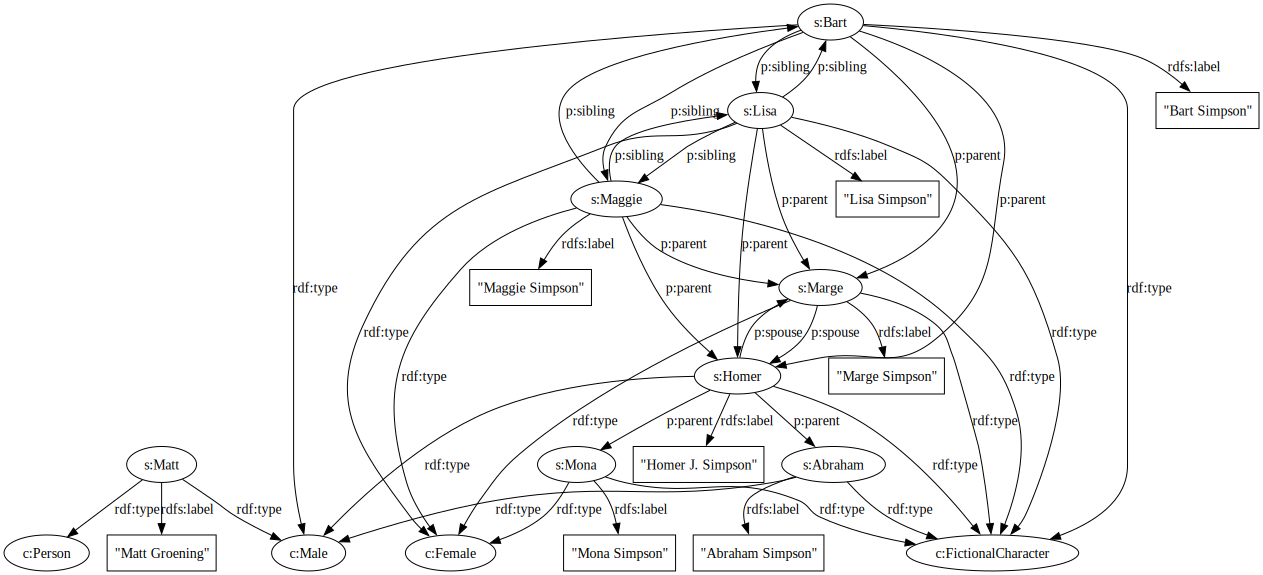

In [4]:
%%rdf turtle -l simpsons
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX s: <http://example.org/subjects#>
PREFIX p: <http://example.org/properties#>
PREFIX c: <http://example.org/classes#>

s:Homer a c:FictionalCharacter, c:Male ;
    p:spouse s:Marge ;
    p:parent s:Abraham ;
    p:parent s:Mona ;
    rdfs:label "Homer J. Simpson" .
s:Marge a c:FictionalCharacter, c:Female ;
    p:spouse s:Homer ;
    rdfs:label "Marge Simpson" .
s:Bart a c:FictionalCharacter, c:Male ;
    p:parent s:Homer ;
    p:parent s:Marge ;
    p:sibling s:Lisa ;
    p:sibling s:Maggie ;
    rdfs:label "Bart Simpson" .
s:Lisa a c:FictionalCharacter, c:Female ;
    p:parent s:Homer ;
    p:parent s:Marge ;
    p:sibling s:Bart ;
    p:sibling s:Maggie ;
    rdfs:label "Lisa Simpson" .
s:Maggie a c:FictionalCharacter, c:Female ;
    p:parent s:Homer ;
    p:parent s:Marge ;
    p:sibling s:Bart ;
    p:sibling s:Lisa ;
    rdfs:label "Maggie Simpson" .
s:Mona a c:FictionalCharacter, c:Female ;
    rdfs:label "Mona Simpson" .
s:Abraham a c:FictionalCharacter, c:Male ;
    rdfs:label "Abraham Simpson" .
s:Matt a c:Person, c:Male ;
    rdfs:label "Matt Groening" .

<div class="alert alert-warning">
    <h3> Important: </h3> <br>
     The cell below will define some prefixes which can be used throughout the whole exercise notebook. You do not need to define them yourself and can just use them. You need to run the cell or you won't be able to use them.
    </div>

In [4]:
%%rdf sparql --prefix
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX s: <http://example.org/subjects#>
PREFIX p: <http://example.org/properties#>
PREFIX c: <http://example.org/classes#>
PREFIX ex: <http://example.org/> 

SPARQL: Stored prefix.


# Task 1 - Basic Queries [1.5 Points]

Formulate the following questions as SPARQL queries using simple SELECT queries, variables and Basic Graph Patterns. You can use as many variables as you need but <b>the answer to the question must be bound to the variable ?result.</b>

<div class="alert alert-warning">
    

For example, if the question is "What is the name of Germany?", the solution would be:
    

    SELECT ?result WHERE {
    ex:Germany rdfs:label ?result
    }
 
    
Please note the difference between a resource (an IRI) and the name of a resource (a human readable literal often assigned with the predicate rdfs:label). Read the question carefully and try to recognize whether we are asking for an entity (e.g. Who is xy?) or for the name of an entity (e.g. What is xy's name?).This task refers to this graph about a family called Simpsons. Assume a closed world (information that isn't explicitly stated is false).    </div>

## Example Query (Try it!)

### Who are Homer Simpson's parents?

In [5]:
%%rdf sparql -l simpsons -s example

SELECT ?result
WHERE {
    s:Homer p:parent ?result
}

?result
http://example.org/subjects#Abraham
http://example.org/subjects#Mona


# a) Who are Marge Simpson's children? [0.5 Points]

In [ ]:
%%rdf sparql -l simpsons -s 1a
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test checks whether your query gives the correct result. [0.5 points]

# b) Who are male characters/persons? [0.5 Points]

In [ ]:
 %%rdf sparql -l simpsons -s 1b
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [0.5 points]

# c) What is the relation between Marge and Homer? [0.5 Points]

In [ ]:
 %%rdf sparql -l simpsons -s 1c
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [0.5 points]

# Task 2 - Constructing Queries [2 Points]

Formulate the following questions as SPARQL queries using simple SELECT queries, variables and Basic Graph Patterns. You can use as many variables as you need but <b>the answer to the question must be bound to the variable ?result.</b>
Again, please note that the URI/IRI of a resource is not the same as the literal name of that resource.

In [ ]:
%%rdf turtle -l royals
PREFIX ex: <http://example.org/> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

ex:Philip ex:Name "Prince Philip" .
ex:ElizabethII ex:Name "Queen Elizabeth II" .
ex:Camilla ex:Name "Camilla Parker" .
ex:CharlesIII ex:Name "King Charles III" .
ex:Diana ex:Name "Princess Diana" .
ex:William ex:Name "Prince William" .
ex:Catherine ex:Name "Catherine Middleton" .
ex:Harry ex:Name "Prince Harry" .
ex:Meghan ex:Name "Meghan Markle" .

ex:Philip ex:Duke ex:Edinburgh .
ex:Philip ex:AKA "Duke of Edinburgh" . 
ex:Philip ex:MarriedTo ex:ElizabethII .
ex:Philip ex:HasChild ex:CharlesIII . 

ex:ElizabethII ex:Queen ex:UK .
ex:ElizabethII ex:RuledFor "70"^^xsd:int .
ex:ElizabethII ex:MarriedTo ex:Philip .
ex:ElizabethII ex:HasChild ex:CharlesIII .

ex:Camilla ex:Duchess ex:Cornwall .
ex:Camilla ex:AKA "Duchess of Cornwall" . 
ex:Camilla ex:MarriedTo ex:CharlesIII .

ex:CharlesIII ex:King ex:UK .
ex:CharlesIII  ex:MarriedTo ex:Camilla  .
ex:CharlesIII  ex:DivorcedWith ex:Diana .
ex:CharlesIII  ex:ChildOf ex:ElizabethII . 
ex:CharlesIII  ex:ChildOf ex:Philip . 
ex:CharlesIII  ex:HasChild  ex:William . 
ex:CharlesIII  ex:HasChild ex:Harry . 

ex:Diana ex:Princess ex:Wales .
ex:Diana ex:AKA "Princess of Wales" . 
ex:Diana ex:DivorcedWith ex:CharlesIII .
ex:Diana ex:HasChild ex:William . 
ex:Diana ex:HasChild ex:Harry . 

ex:Catherine ex:Duchess ex:Cambridge .
ex:Catherine ex:AKA "Duchess of Cambridge" . 
ex:Catherine ex:MarriedTo ex:William .

ex:William ex:Duke ex:Cambridge .
ex:William ex:AKA "Duke of Cambridge" . 
ex:William ex:MarriedTo ex:Catherine .
ex:William ex:ChildOf ex:Diana . 
ex:William ex:ChildOf ex:CharlesIII . 

ex:Meghan ex:Duchess ex:Wales .
ex:Meghan ex:AKA "Duchess of Wales" . 
ex:Meghan ex:MarriedTo ex:Harry .

ex:Harry ex:Duke ex:Wales .
ex:Harry ex:AKA "Duke of Wales" . 
ex:Harry ex:MarriedTo ex:Meghan .
ex:Harry ex:ChildOf ex:Diana . 
ex:Harry ex:ChildOf ex:CharlesIII . 

### 2a) Who is called "Camilla Parker"? Hint: Basic Graph Patterns can also match literals for equality. We are looking for the entity, which has the (string) name "Camilla Parker". [0.5 Points]

In [ ]:
%%rdf sparql -l royals -s 2a
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [0.5 points]

### 2b) What are the names (the string name!) of all grand-children of Elizabeth II? [0.5 Points]

In [ ]:
%%rdf sparql -l royals -s 2b
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
 # This test will check whether your query returns the right results. [0.5 points]

### 2c) What are the titles (AKA) of persons, who are married to a person, who has divorced parents? [1 Points]

<div class="alert alert-warning">
    <h3> Important: </h3> <br>
Do not use the DISTINCT keyword.
    Note: This query will yield the same binding for ?result multiple times. Think about why that is. If you can't think of a reason try projecting the other variables as well. The query should return 4 results.
    </div>

In [ ]:
%%rdf sparql -l royals -s 2c
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [1 point]

# Graph: Scientists
The following graph contains information about some well-known scientists. **You must run the following cell, otherwise the graph won't be in scope for the tasks:**

In [ ]:
%%rdf turtle -l scientists
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX s: <http://example.org/subjects#>
PREFIX p: <http://example.org/properties#>
PREFIX c: <http://example.org/classes#>

s:Einstein a c:Person, c:Physicist ;
    p:born "1879"^^xsd:integer ;
    p:wonNobelPrize "1921"^^xsd:integer ;
    rdfs:label "Albert Einstein" .
s:Nobel a c:Person, c:Chemist ;
    p:born "1833"^^xsd:integer ;
    rdfs:label "Alfred Nobel" .
s:Curie a c:Person, c:Physicist, c:Chemist ;
    p:born "1867"^^xsd:integer ;
    p:wonNobelPrize "1903"^^xsd:integer ;
    p:wonNobelPrize "1911"^^xsd:integer ;
    rdfs:label "Marie Curie" .
s:Koch a c:Person, c:Physician, c:Microbiologist ;
    p:born "1843"^^xsd:integer ;
    p:wonNobelPrize "1905"^^xsd:integer ;
    rdfs:label "Robert Koch" .
s:Röntgen a c:Person, c:Physicist ;
    p:born "1845"^^xsd:integer ;
    p:wonNobelPrize "1901"^^xsd:integer ;
    rdfs:label "Wilhelm Conrad Röntgen" .

# Task 3: Modifying Solutions [2.5 points]

Formulate the following questions as SPARQL queries using simple SELECT queries, variables and Basic Graph Patterns.</b>
Again, please note that the URI/IRI of a resource is not the same as the literal name of that resource.

### 3a) The birth year of all persons that have won a nobel prize, ordered DESC, and without duplicates. Use variable **?year** for the year. Your query should give 4 entries. [0.5 points]

In [ ]:
%%rdf sparql -l scientists -s 3a
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [0.5 points]

### 3b) The third, fourth, and fifth nobel prize sorted ascending by year with their respective owner's name. Use variable ?year for the year and ?name for the name. [1 point]

In [ ]:
%%rdf sparql -l scientists -s 3b
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [1 point]

### 3c) The name and birth year of the owner of the last nobel prize, who was a chemist. Use variable ?name for the name and ?year for the birth year. [1 point]

In [ ]:
 %%rdf sparql -l scientists -s 3c
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check whether your query returns the right results. [1 point]

# Task 4: Filters, Functions, Modifiers, and Aggregates [10 Points]
The following graph contains information about some famous onde day international (ODI) Cricketers of 90s. In the following tasks, we ask you to perform SPARQL query covering filter, modifiers, and aggregation operations. Before we formally define the task, we provide some quick overview of Filters, Functions, Modifiers and Aggregates. 

### Filters, Modifiers, and Aggregates
With Group Graph Patterns and Solution Modifiers we can efficiently query RDF graphs but what if we actually want to do something with the data like calculating an average, filtering specific values or binding our own values? There are many ways to do this and we will introduce the most important ones.

#### Filters
One can filter values inside a Group Graph Pattern by using the **FILTER** function. Inside the parentheses of the filter function we have to provide a filter expression. A Filter expression uses operators like \<, =, \> \<=, \>= and != to compare variables and literals with specific data types. We can also use arithmetic operators like +, -, \* and /. We can also combine multiple filter expressions with AND (&&), OR (||) and NOT (!). Filters are always applied to the whole Group Pattern in which they reside. There are also many functions which can be used in filter expressions like **contains** which checks if a string contains another string or **str** which converts a literal to its literal value (without data type) or **regex** which matches a string with a full regular expression. Example:

SELECT \* WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;?employee a c:Employee ;  
&nbsp;&nbsp;&nbsp;&nbsp;?employee rdfs:label ?name ;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;p:income ?income .  
&nbsp;&nbsp;&nbsp;&nbsp;FILTER (str(?name) != "Angela" && contains(?name, "la") && ?income > 450)  
}

Here we show all employees with their name and income who have an income larger than 450, aren't called "Angela" and whose name contains "la".

#### Aggregates
To calculate values over multiple results, we need to use aggregate functions. The most important aggregate functions are min, max, avg, sum and count. These can simply be used in the projection. Aggregate functions always work on groups of results and compute separately for each group. By default all results are one big group but you can use the **GROUP BY** modifier to specify a variable to group by. For example if you want to know for all employers what the average income of their employees is, you could do it like this:

SELECT ?employer (sum(?income) AS ?incomeSum) WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;?employer a c:Employer .  
&nbsp;&nbsp;&nbsp;&nbsp;?employee a c:Employee ;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;p:worksFor ?employer ;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;p:income ?income .   
}
GROUP BY ?employer

Please note that it is obligatory to bind the result with the **AS** keyword and surround the expression with parentheses. You can also use other functions and arithmetic operators on the left side of the AS, for example to remove a 10% tax you could do **(sum(?income)*0.9 AS ?incomeSum)** instead.

#### Manual Binding
One can also bind their own values to variables using the BIND keyword. If you want to get the difference in population of Germany and Sweden:

SELECT ?diff WHERE {  
&nbsp;&nbsp;&nbsp;&nbsp;s:Germany p:population ?x .  
&nbsp;&nbsp;&nbsp;&nbsp;s:Sweden p:population ?y .  
&nbsp;&nbsp;&nbsp;&nbsp;BIND (abs(?x - ?y) AS ?diff)  
}

Again, you can use all kinds of expressions on the left side of the AS keyword. 

## **Now run the following cell, otherwise the graph won't be in scope for the tasks!**

In [ ]:
%%rdf turtle -l odi_cricketers_90s
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX s: <http://example.org/subjects#>
PREFIX p: <http://example.org/properties#>
PREFIX c: <http://example.org/classes#>

s:Tendulkar a c:Cricketer ;
    p:hasName "Sachin Tendulkar"^^xsd:string ;
    p:hasRuns "18426"^^xsd:integer ;
    p:hasAverage "44.83"^^xsd:float ;
    p:hasCentury "49"^^xsd:integer ;
    p:battingPosition "Top order"^^xsd:string ;
    p:hasCountry "India"^^xsd:string ;
    rdfs:label "Little Master" .

s:Sangakkara a c:Cricketer ;
    p:hasName "Kumar Sangakkara"^^xsd:string ;
    p:hasRuns "14234"^^xsd:integer ;
    p:hasAverage "42.03"^^xsd:float ;
    p:hasCentury "30"^^xsd:integer ;
    p:battingPosition "Middle order"^^xsd:string ;
    p:hasCountry "Sri Lanka"^^xsd:string .

s:Ponting a c:Cricketer ;
    p:hasName "Ricky Ponting"^^xsd:string ;
    p:hasRuns "13704"^^xsd:integer ;
    p:hasAverage "41.98"^^xsd:float ;
    p:hasCentury "25"^^xsd:integer ;
    p:battingPosition "Top order"^^xsd:string ;
    p:hasCountry "Australia"^^xsd:string ;
    rdfs:label "Punter" .

s:Jayasuriya a c:Cricketer ;
    p:hasName "Sanath Jayasuriya"^^xsd:string ;
    p:hasRuns "13430"^^xsd:integer ;
    p:hasAverage "32.36"^^xsd:float ;
    p:hasCentury "28"^^xsd:integer ;
    p:battingPosition "Top order"^^xsd:string ;
    p:hasCountry "Sri Lanka"^^xsd:string ;
    rdfs:label "Matara Hurricane" .

s:Inzamam a c:Cricketer ;
    p:hasName "Inzamam-ul-Haq"^^xsd:string ;
    p:hasRuns "11739"^^xsd:integer ;
    p:hasAverage "39.52"^^xsd:float ;
    p:hasCentury "10"^^xsd:integer ;
    p:battingPosition "Middle order"^^xsd:string ;
    p:hasCountry "Pakistan"^^xsd:string ;
    rdfs:label "Inzi" .

s:Anwar a c:Cricketer ;
    p:hasName "Saeed Anwar"^^xsd:string ;
    p:hasRuns "8824"^^xsd:integer ;
    p:hasAverage "39.21"^^xsd:float ;
    p:hasCentury "20"^^xsd:integer ;
    p:battingPosition "Top order"^^xsd:string ;            
    p:hasCountry "Pakistan"^^xsd:string ;
    rdfs:label "Majestic Lefthander" .

s:Gilchrist a c:Cricketer ;
    p:hasName "Adam Gilchrist"^^xsd:string ;
    p:hasRuns "9619"^^xsd:integer ;
    p:hasAverage "35.89"^^xsd:float ;
    p:hasCentury "16"^^xsd:integer ;
    p:battingPosition "Top order"^^xsd:string ;
    p:hasCountry "Australia"^^xsd:string ;
    rdfs:label "Gilly" .

s:Villiers a c:Cricketer ;
    p:hasName "AB de Villiers"^^xsd:string ;
    p:hasRuns "9577"^^xsd:integer ;
    p:hasAverage "53.5"^^xsd:float ;
    p:hasCentury "25"^^xsd:integer ;
    p:battingPosition "Middle order"^^xsd:string ;
    p:hasCountry "South Africa"^^xsd:string ;
    rdfs:label "Mr. 360" .

s:Kallis a c:Cricketer ;
    p:hasName "Jacques Kallis"^^xsd:string ;
    p:hasRuns "11579"^^xsd:integer ;
    p:hasAverage "44.36"^^xsd:float ;
    p:hasCentury "17"^^xsd:integer ;
    p:battingPosition "Middle order"^^xsd:string ;
    p:hasCountry "South Africa"^^xsd:string ;
    rdfs:label "Broad-shouldered colossus of South Africa" .

s:Lara a c:Cricketer ;
    p:hasName "Brian Lara"^^xsd:string ;
    p:hasRuns "10405"^^xsd:integer ;
    p:hasAverage "40.48"^^xsd:float ;
    p:hasCentury "19"^^xsd:integer ;
    p:battingPosition "Top order"^^xsd:string ;
    p:hasCountry "West Indies"^^xsd:string ;
    rdfs:label "Princes of Cricket" .


## Task: 4a) [1 point]
Which is the leading run scorer (has the highest run) in the ODI Cricket? Use variables **?batsman** for the batsman's name and **?runs** for the total runs.

In [ ]:
%%rdf sparql -l odi_cricketers_90s -s 4a
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check if the leading run scorer is reported w.r.t highest number of runs cored in ODI Cricket. [1 point]

## Task: 4b) [1 point]
Find the average runs scored by these batters. Use variables **?avgRuns** to show the rounded (**ROUND**) result. **Hint:** There are ten players. Calculate the sum of all runs and divide by 10. The result of this fraction should be stored in **?avgRuns**.

In [ ]:
%%rdf sparql -l odi_cricketers_90s -s 4b
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check if average runs scored by these batters is correctly rounded and reported. [1 point]

## Task: 4c) [2 points]
Rank the batsmen in ascending order of their ODI runs. Additionally, report individual's average and number of centuries. Use variables **?batsman**, **?runs**, **?centuries**, and **?average** for a batsman's name, total runs scored, number of centuries, and average, respectively. 

In [ ]:
%%rdf sparql -l odi_cricketers_90s -s 4c
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check if the batsmen are sorted in ascending order of their ODI runs. [2 points]

## Task: 4d) [2 points]
Who are the top-3/best middle-order batsmen in ODI Cricket, whose average is above 40? Use variables **?name**, **?position**, and **?average** for batsman's name, batting position, and their average, respectively. Also, sort them in according order of their average (DESC). 

In [ ]:
%%rdf sparql -l odi_cricketers_90s -s 4d
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will retrieve top-3 middle-order batsmen in ODI Cricket, whose average is above 40. [2 points]

## Task: 4e) [2 points]
As seen, some batsmen are also internationally well-known with given names/title by Cricket fans, e.g., Sanath Jayasuriya is known as "Matara Hurricane". But which batsmen did **NOT** get a such a popular name/title. Use variables **?name** for their real names. 

In [ ]:
%%rdf sparql -l odi_cricketers_90s -s 4e
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check if there is a batsman without a nickname. [2 points]

## Task: 4f) [2 points]
What is the run difference between top-2 batsmen? **Hints**: based on question 4)c, you can apply manual binding using keyword **BIND**. Use variables **?diffRuns** for the difference. 

In [ ]:
%%rdf sparql -l odi_cricketers_90s -s 4f
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# This test will check if the difference correct. [2 points]